# 0. 0 IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import seaborn as sns
import numpy
import pickle
import warnings
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


warnings.filterwarnings('ignore')

# 0.1 Helper Functions

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )




def ml_error(model_name, y, yhat):
    mae= mean_absolute_error(y, yhat)
    mape=mean_absolute_percentage_error(y, yhat)
    rmse= mean_squared_error(y, yhat)
    
    return pd.DataFrame({'Model Name': model_name, 
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index = [0])

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.rcParams['figure.figsize'] = (20,11)
    sns.set()

## 0.2 Loading Data

In [72]:
df_sales_raw = pd.read_csv('C:/Users/Joâo Victor/Desktop/DS em Produção/train.csv', low_memory = False)
df_store_raw = pd.read_csv('C:/Users/Joâo Victor/Desktop/DS em Produção/store.csv', low_memory = False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on = 'Store')


# 1.0 DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns

In [4]:
df1 = df_raw.copy()
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_news = list(map(snakecase, cols_old))

#rename
df1.columns = cols_news
#df1.columns



## 1.2 Data Dimensions

In [5]:
print('Number of raws:', df1.shape[0])
print('Number of columns', df1.shape[1])


Number of raws: 1017209
Number of columns 18


## 1.2 Data Types

In [6]:
df1['date'] = pd.to_datetime(df1['date'])
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.3 Check NA

In [7]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [8]:
df1['competition_distance'].max()

75860.0

In [9]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
322494,112,2,2014-09-30,6730,778,1,1,0,0,a,a,1630.0,9.0,2009.0,0,NaN,NaN,NaN


## 1.5. Fillout NA

In [10]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


## 1.6 Change Types

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [12]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)


df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

### 1.7.1 Numeric Attributes


In [13]:
num_attributes = df1.select_dtypes(include = ['int32', 'int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int32', 'int64', 'float64', 'datetime64[ns]'])
num_attributes

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1900.0,6,2014,1,31,2013,1
1017205,1112,2,0,0,0,0,1,1880.0,4,2006,0,1,2013,0
1017206,1113,2,0,0,0,0,1,9260.0,1,2013,0,1,2013,0
1017207,1114,2,0,0,0,0,1,870.0,1,2013,0,1,2013,0


In [14]:
#Central Tendency - Mean and median
ct1 = pd.DataFrame(num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame(num_attributes.apply( np.median )).T



#Dispersion - std, min, max, range, skew and curtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T


#Concat
m = pd.concat([d1, d2, d3, d4, ct1, ct2, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m




,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,321.908493,1.0,1115.0,1114.0,558.429727,558.0,-0.000955,-1.200524
1,day_of_week,1.997390,1.0,7.0,6.0,3.998341,4.0,0.001593,-1.246873
2,sales,3849.924283,0.0,41551.0,41551.0,5773.818972,5744.0,0.641460,1.778375
3,customers,464.411506,0.0,7388.0,7388.0,633.145946,609.0,1.598650,7.091773
4,open,0.375539,0.0,1.0,1.0,0.830107,1.0,-1.758045,1.090723
5,promo,0.485758,0.0,1.0,1.0,0.381515,0.0,0.487838,-1.762018
6,school_holiday,0.383056,0.0,1.0,1.0,0.178647,0.0,1.677842,0.815154
7,competition_distance,12547.646829,20.0,200000.0,199980.0,5935.442677,2330.0,10.242344,147.789712
8,competition_open_since_month,3.311085,1.0,12.0,11.0,6.786849,7.0,-0.042076,-1.232607
9,competition_open_since_year,5.515591,1900.0,2015.0,115.0,2010.324840,2012.0,-7.235657,124.071304


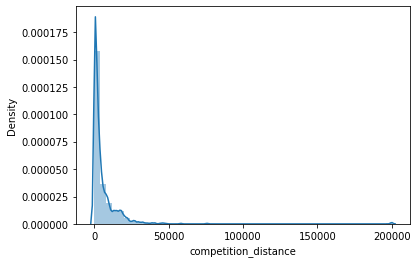

In [15]:
#Insights - Plots
ax = sns.distplot( df1['competition_distance'] )


In [16]:
#1.7.2 Categorical Values
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

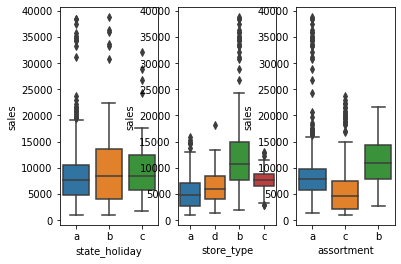

In [17]:
#Removing outliers
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux)
plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux)
plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux)

# 2.0 FEATURE ENGINEERING

## 2.1.1 Mapa mental das hipóteses

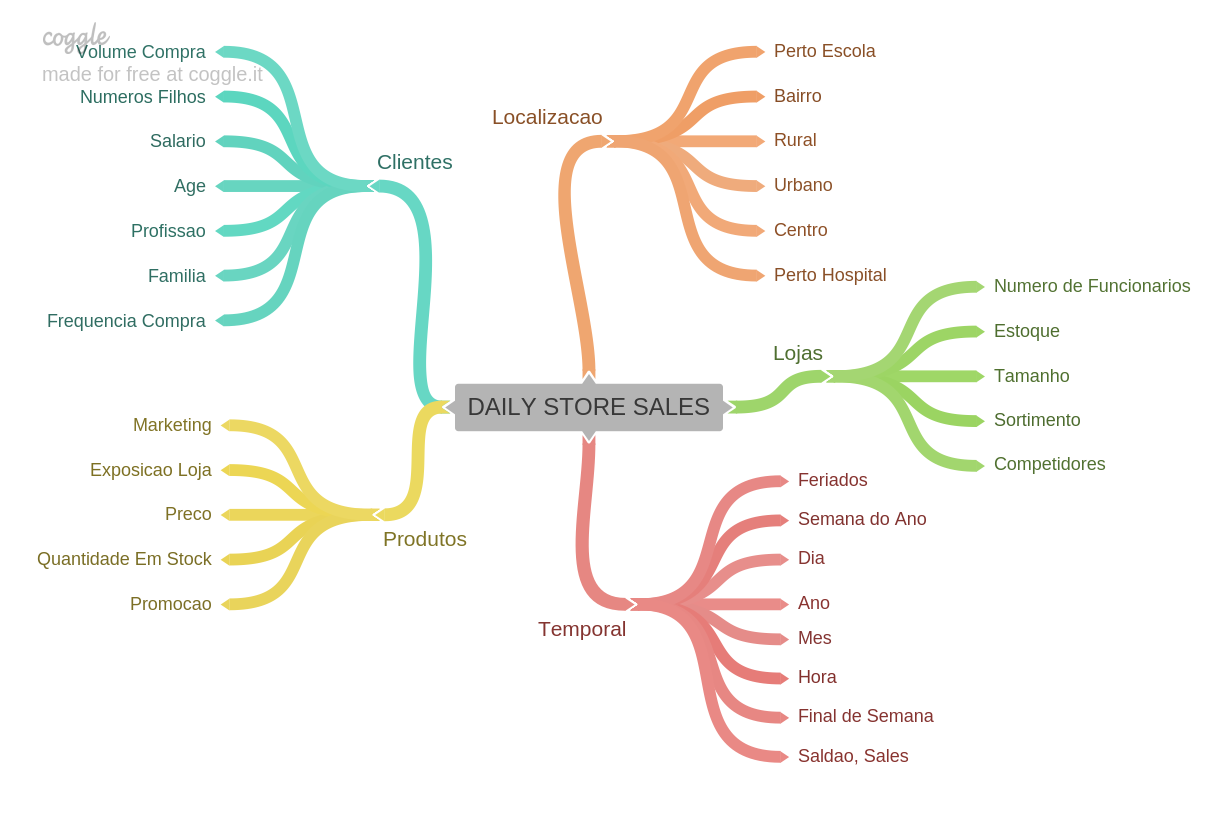

In [18]:
Image('C:/Users/Joâo Victor/Desktop/DS em Produção/Hypothesis.png')

## 2. 2 Criação das hipóteses 

### 2.2.1. Hipoteses Loja


**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.



## 2.3 Feature Engineering

In [19]:
df2 = df1.copy()

In [20]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0


In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [23]:
df2['promo2_since_year'].head(20)

0     2015
1     2010
2     2011
3     2015
4     2015
5     2015
6     2015
7     2015
8     2015
9     2015
10    2012
11    2010
12    2009
13    2011
14    2011
15    2015
16    2010
17    2012
18    2011
19    2014
Name: promo2_since_year, dtype: int32

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 - FILTRAGEM DE VARIÁVEIS 

In [25]:
df3 = df2.copy()
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.1 Filtragem das Linhas

In [26]:
df3 = df3[(df3['open'] !=0)  & (df3['sales'] > 0)]  #quero apenas as lojas abertas 
#se loja =0, ou seja, fechada, estão as vendas são zero.


## 3.2 Seleção das Colunas

In [27]:
cols_drop = ['customers' ,'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [28]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4. EDA - Análise Exploratória dos dados

In [29]:
df4 = df3.copy()
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270.0,570.0,14130.0,620.0,29910.0


## 4.1 Análise Univariada

## 4.1.1. Response Variable

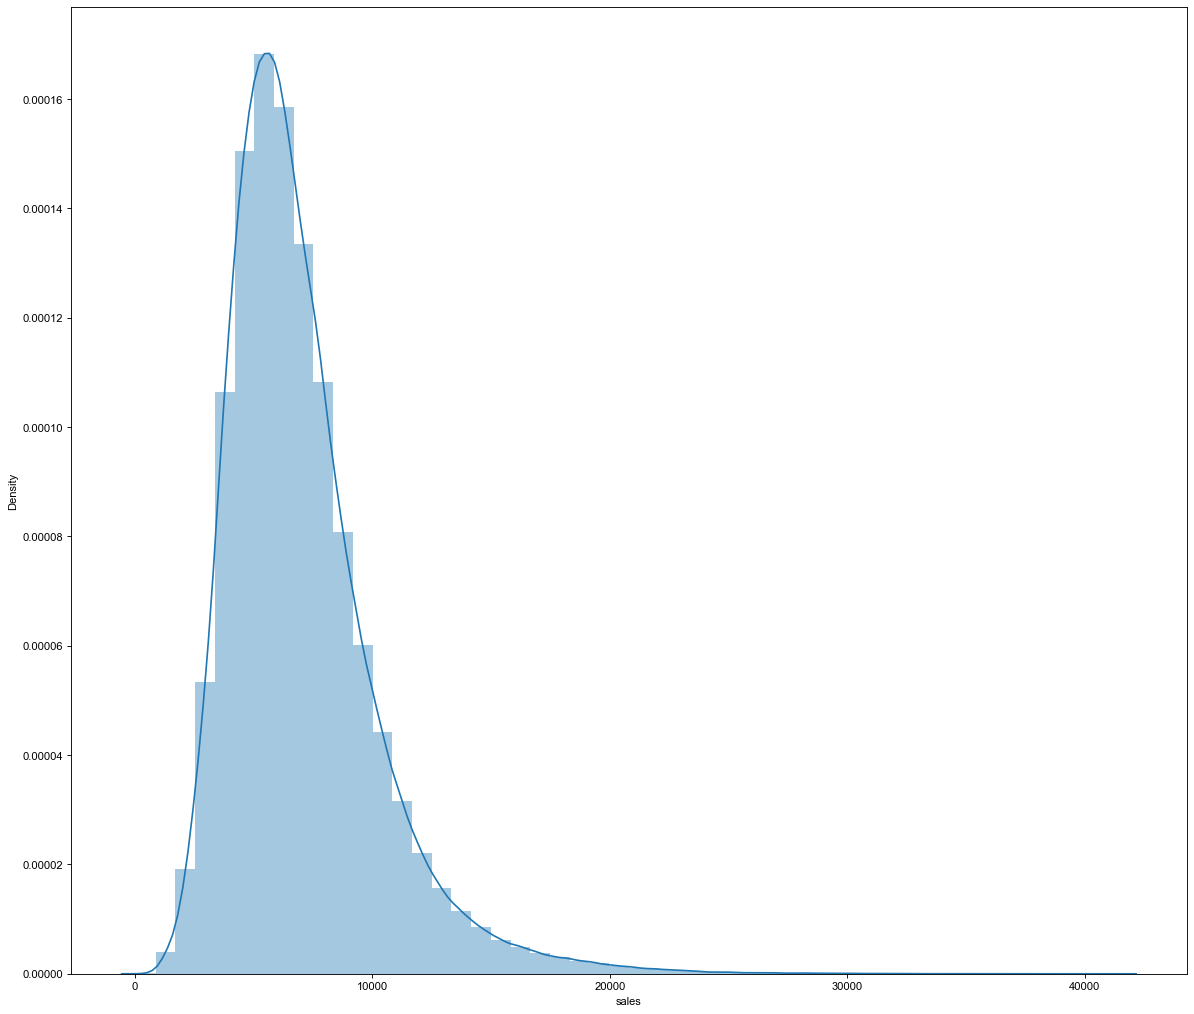

In [30]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
sns.distplot(df4['sales']);
sns.set_style("dark")


## 4.1.2. Numerical Variable

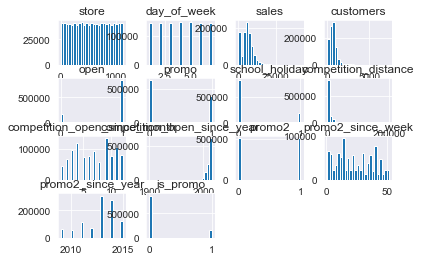

In [31]:
num_attributes.hist(bins = 25);



## 4.1.3 Variável Categórica

<AxesSubplot:xlabel='sales', ylabel='Density'>

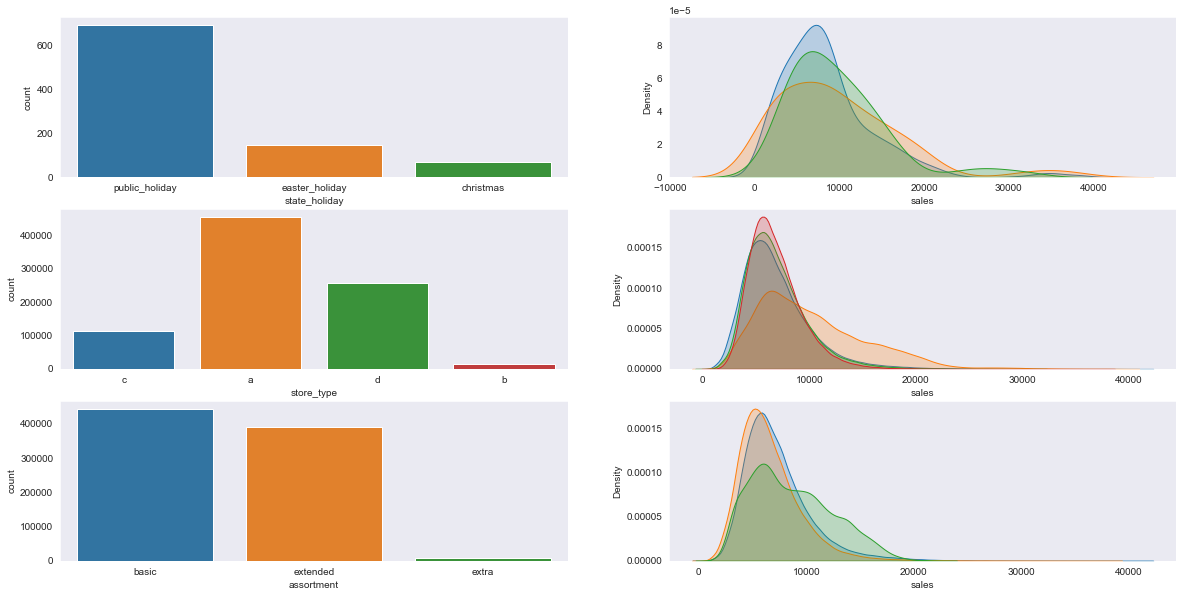

In [32]:
#state_holiday
plt.figure(figsize = [20,10])
plt.subplot(3, 2, 1)

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])


plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True);


#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)

sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)

sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)

sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)


#assortment
plt.subplot(3, 2, 5)

sns.countplot(df4['assortment'])


plt.subplot(3, 2, 6)

sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)

sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)

sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)




## 4.2 Análise Bivariada

## **1.** Lojas com maior sortimentos deveriam vender mais. Falso! Na verdade, vendem menos!



<AxesSubplot:xlabel='year_week'>

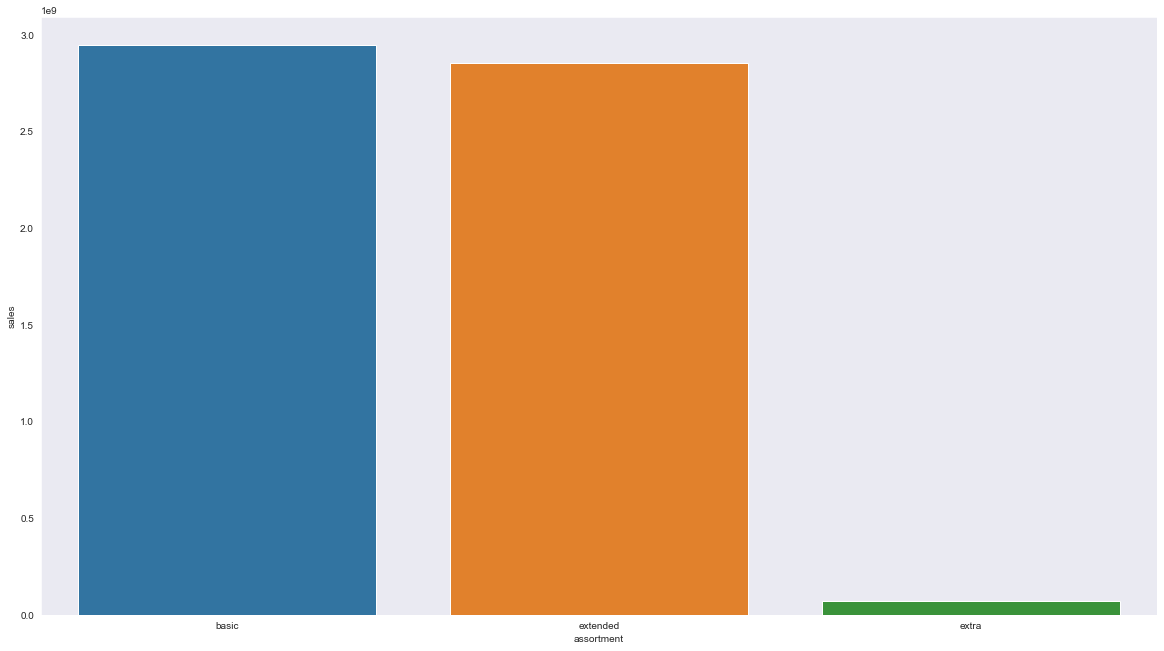

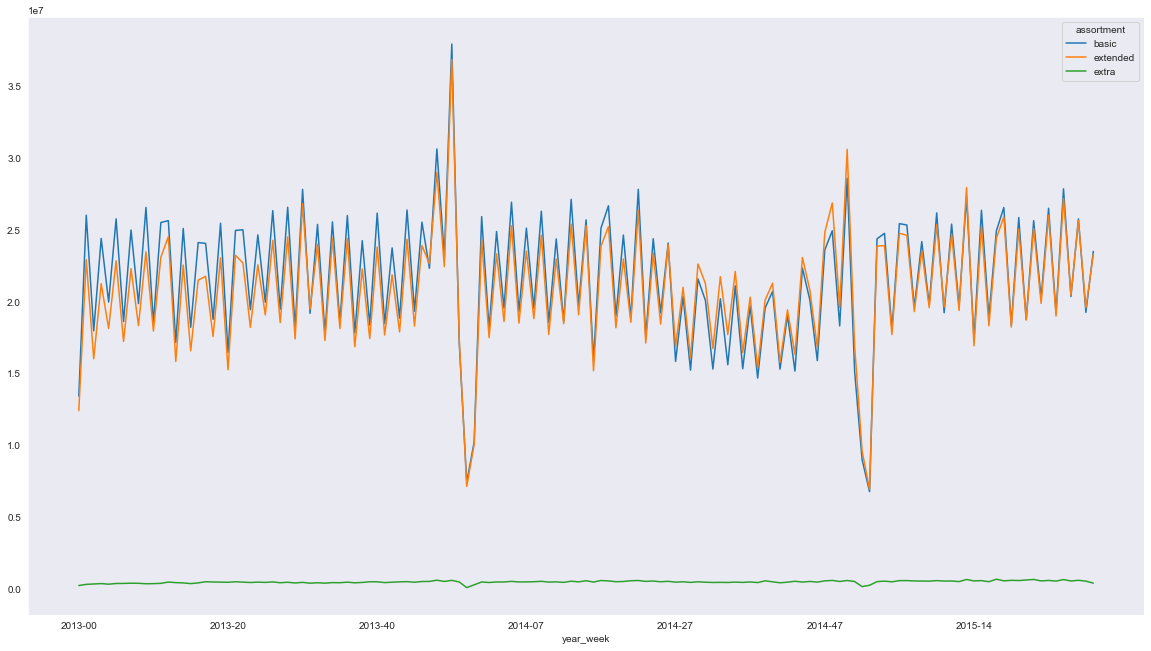

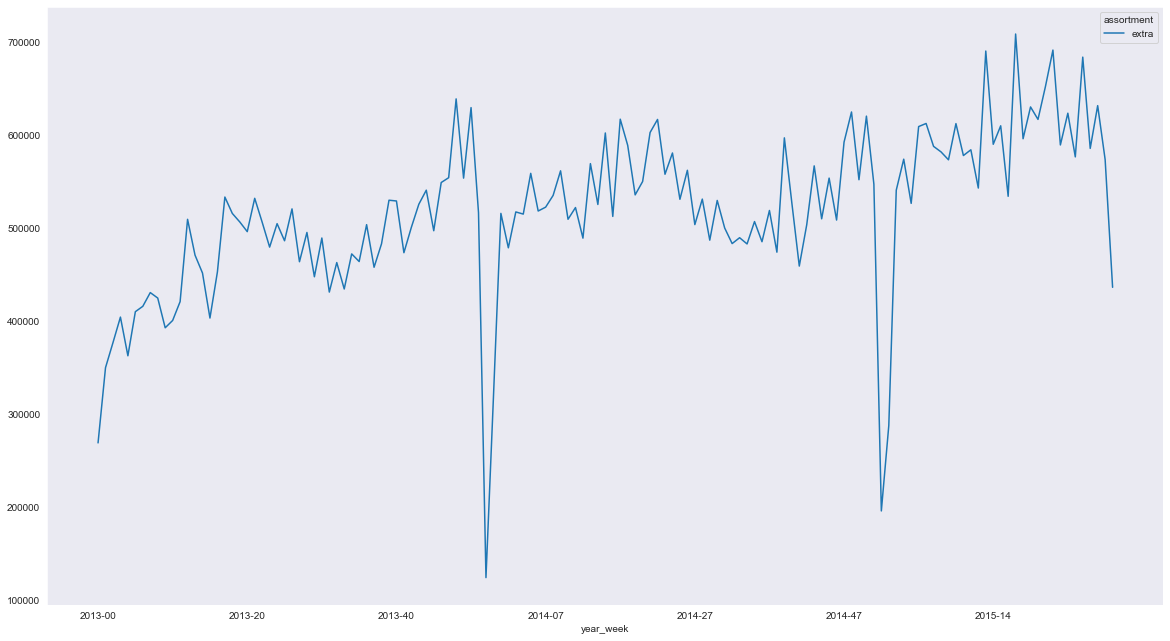

In [33]:
plt.rcParams['figure.figsize'] = (20,11)
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

#Será que, na verdade, houve uma mudança de comportamento de extra?

#Podemos, então, tentar enxergar algum comportamento de "extra" ao longo do tempo;
aux2= df4[['assortment', 'sales', 'year_week']].groupby(['assortment', 'year_week']).sum().reset_index()


#Para fazermos um plot do gráfico de linhas de cada um assortment, o ideal é que cada linha seja única;
#Para que tenhamos um comportamento único para cada linha

plot1 = aux2.pivot(index = 'year_week', columns= 'assortment', values = 'sales').plot()


#Filtrando aux2 por extra
aux3 = aux2[aux2['assortment'] == 'extra']


#pivotando e plotando o gráfico
aux3.pivot(index ='year_week', columns = 'assortment', values = 'sales').plot()

## **2.** Lojas com competidores mais próximos deveriam vender menos. Falsa. Caso Contrário;



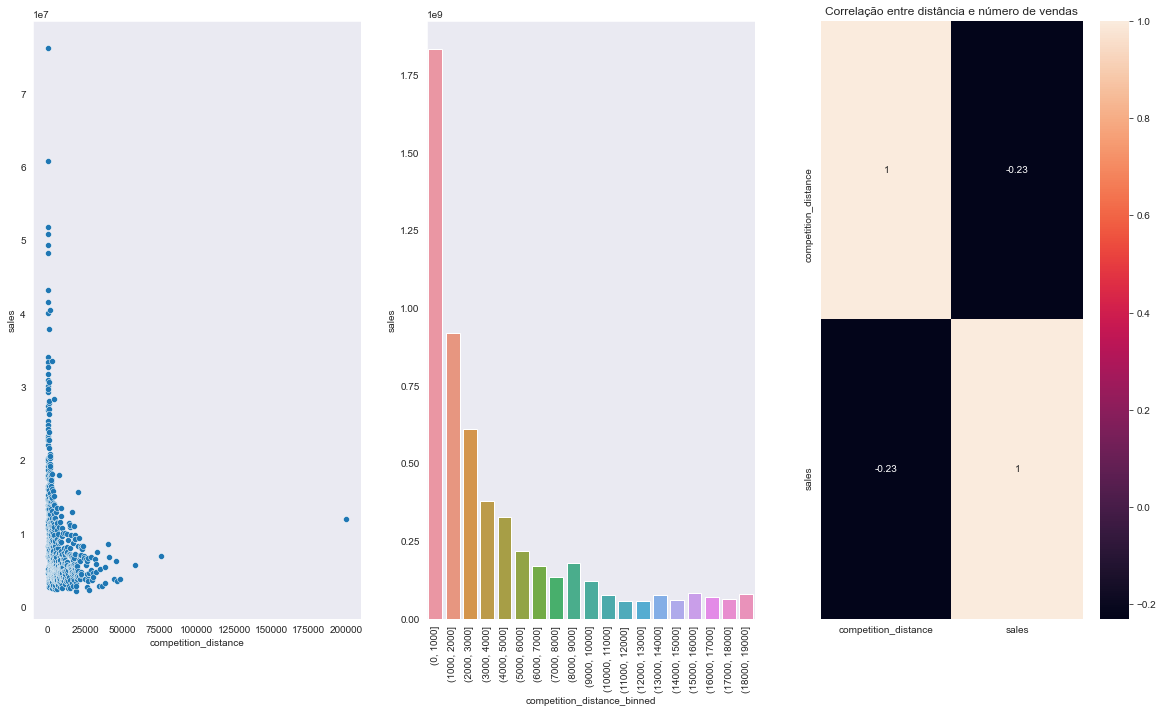

In [34]:


aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()



plt.subplot(1, 3, 1)
#Perceba que este gráfico tem uma granularidade muito alta, uma maneira alternativa de fazer isso seria utilizando um scatterplot

#sns.barplot(x = 'competition_distance', y = 'sales', data = aux1)

#scatterplot
sns.scatterplot(x= 'competition_distance', y='sales', data = aux1); #Perceba que funciona;



#Imagine, do contrário, que queiramos ver esses valores do scatterplot em um barplot;
#Teremos, então, que separá-los em um grupo de valores de distância. Para isso utilizamos o método "cut" do pandas e uma lista;

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins) 
aux2 = aux1[['competition_distance_binned', 'sales']]. groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1, 3, 2)
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);



#Correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True )
plt.title('Correlação entre distância e número de vendas');




## **3.** Lojas com competidores à mais tempo deveriam vendem mais.


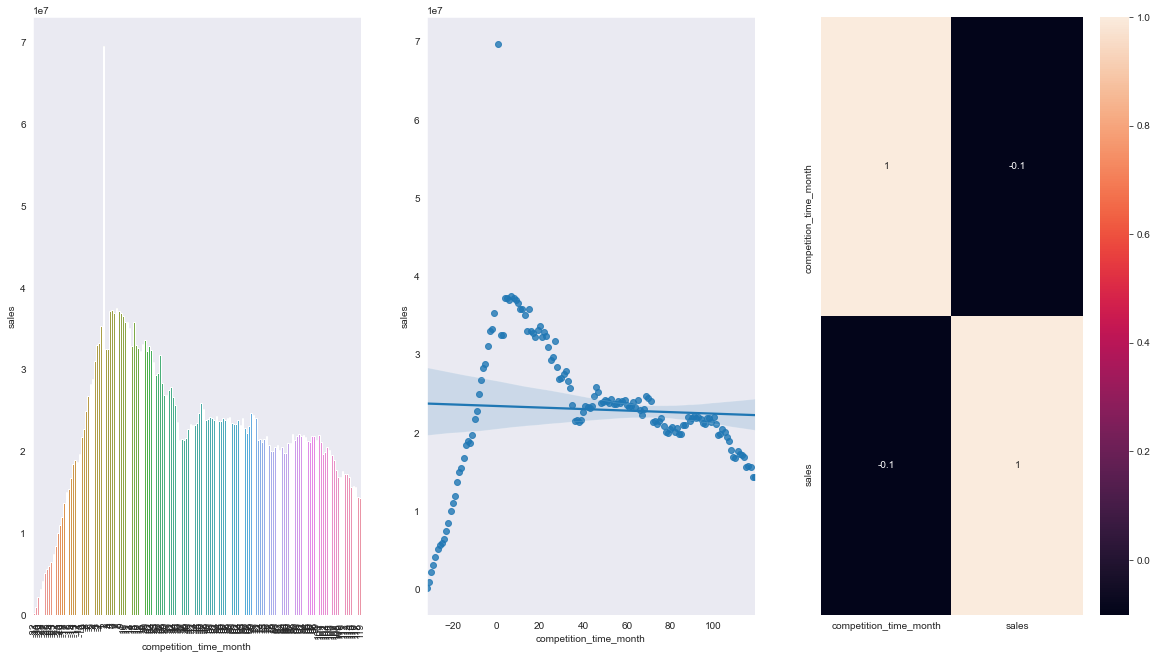

In [35]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

##Filtro ##
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]

##       ##
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );

## 4. Lojas com promoções ativas por mais tempo devem vender mais.

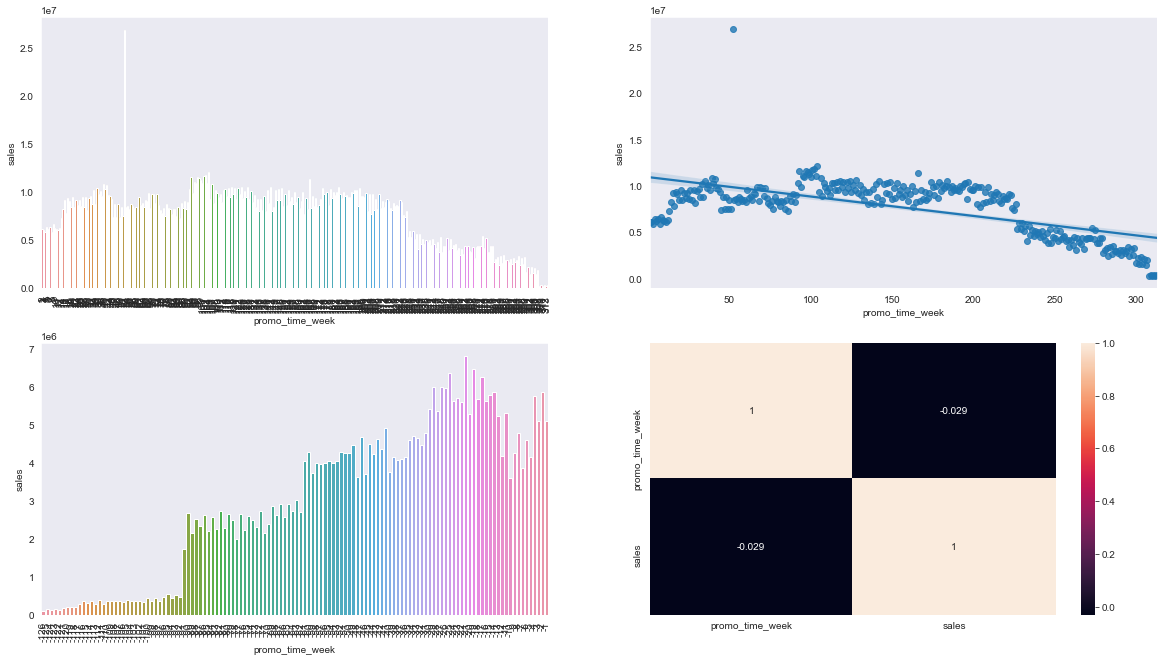

In [36]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

plt.subplot( 2, 2, 1 )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( 2, 2, 3 )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( 2, 2, 4 )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( 2, 2, 4 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H7.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

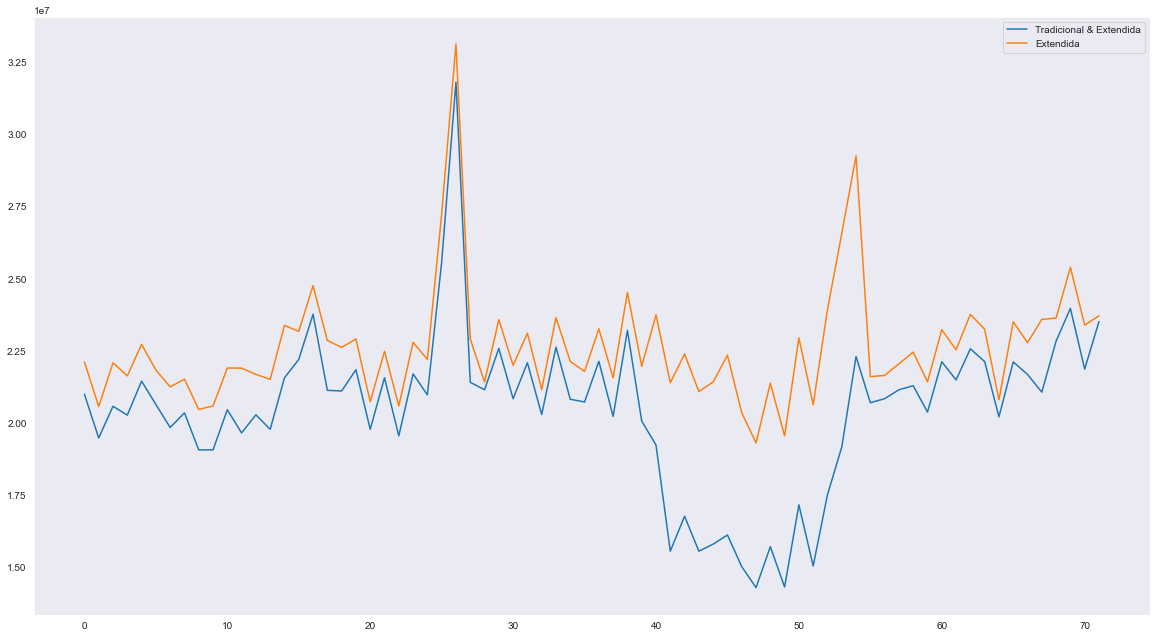

In [37]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

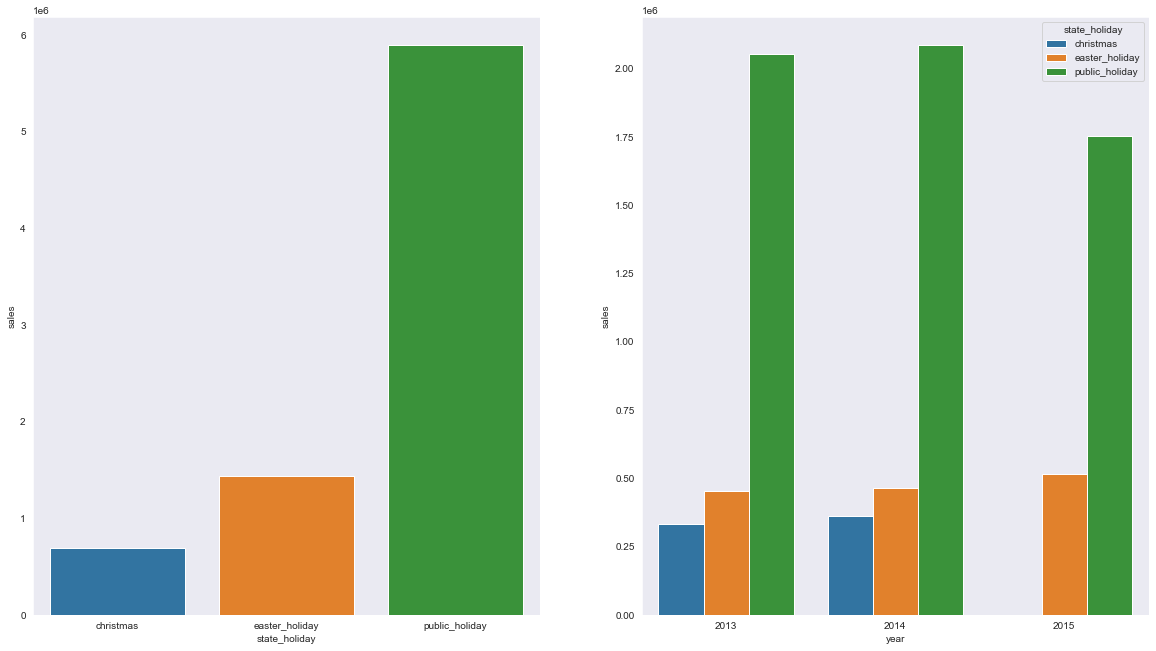

In [38]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x = 'state_holiday', y='sales', data = aux1);

#Quero analisar para  ver se em algum momento isso é diferente;
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

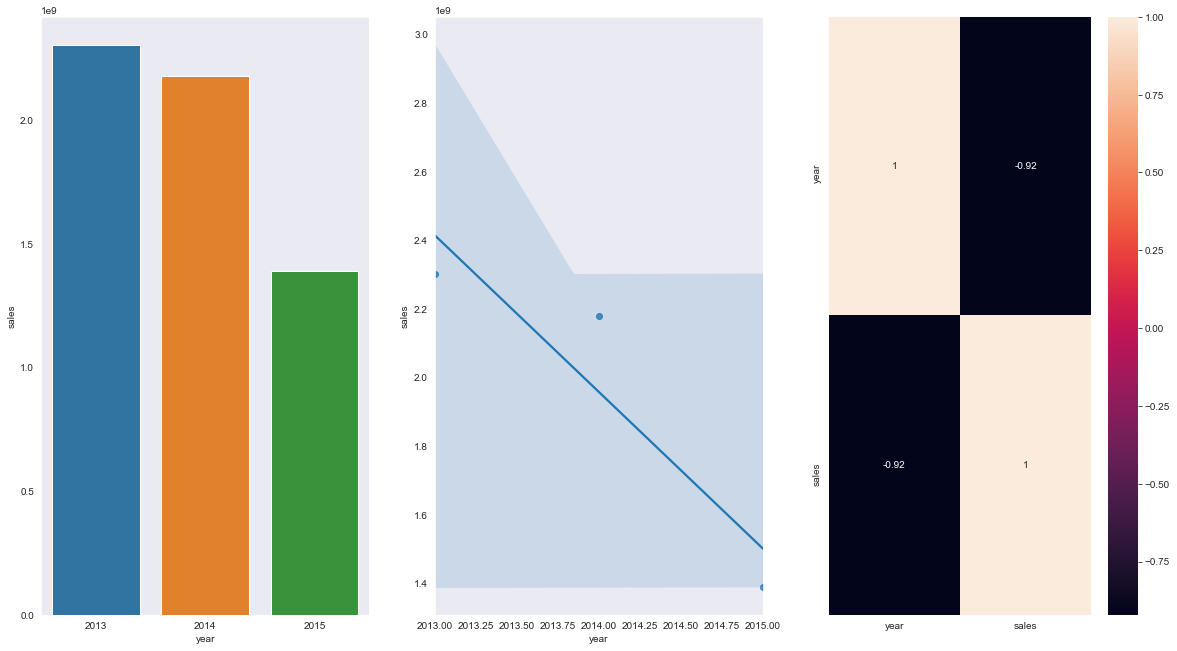

In [39]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

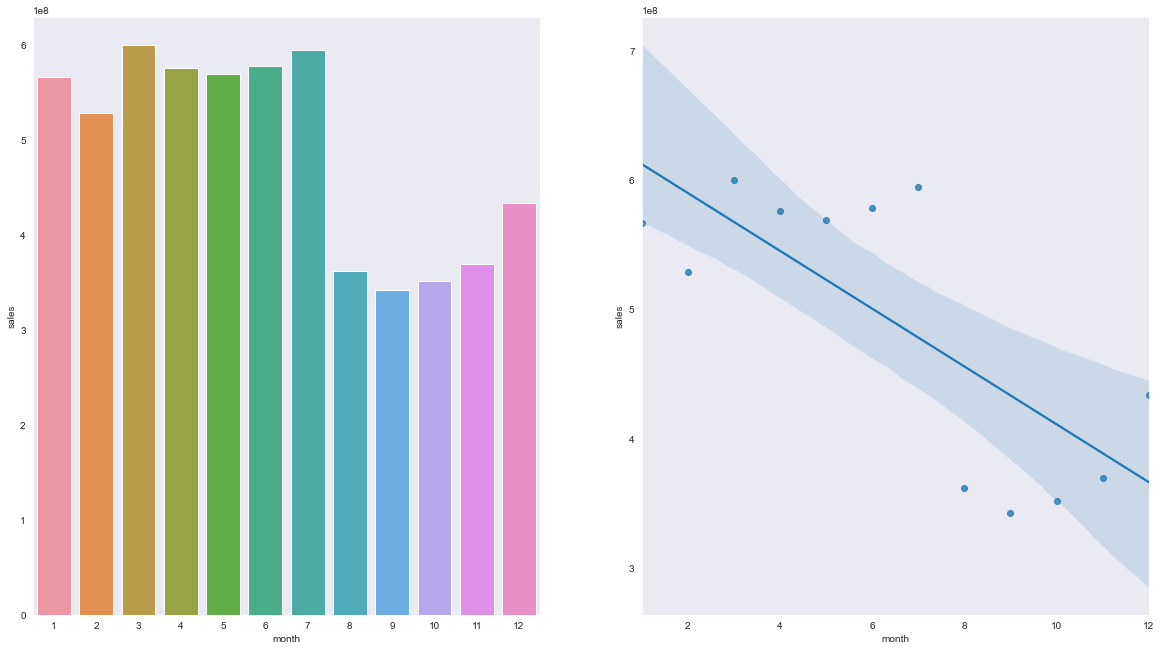

In [40]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x = 'month', y='sales', data = aux);


#Há tendência?

plt.subplot(1,2,2)
sns.regplot(x='month', y='sales', data = aux);

### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

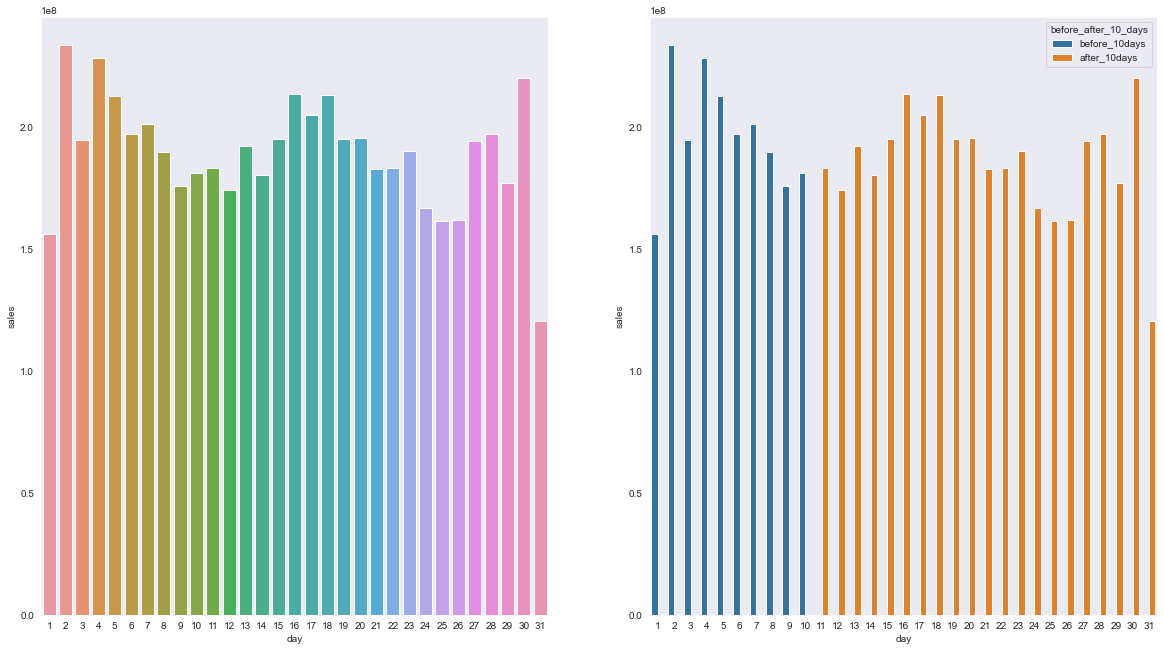

In [41]:
aux = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(x = 'day', y = 'sales', data = aux);


aux['before_after_10_days'] = aux['day'].apply(lambda x: 'before_10days' if x<= 10 else 'after_10days')
plt.subplot(1, 2, 2)
sns.barplot(x = 'day', y = 'sales', hue = 'before_after_10_days', data = aux);


### **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

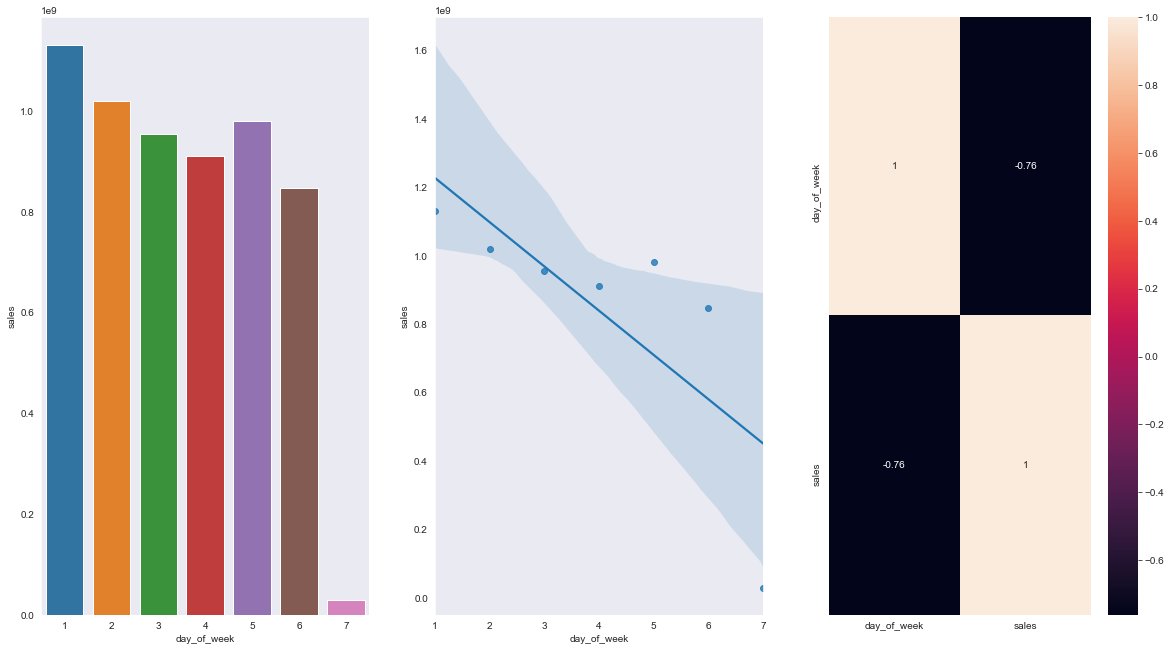

In [42]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, except os meses de Julho e Agosto.

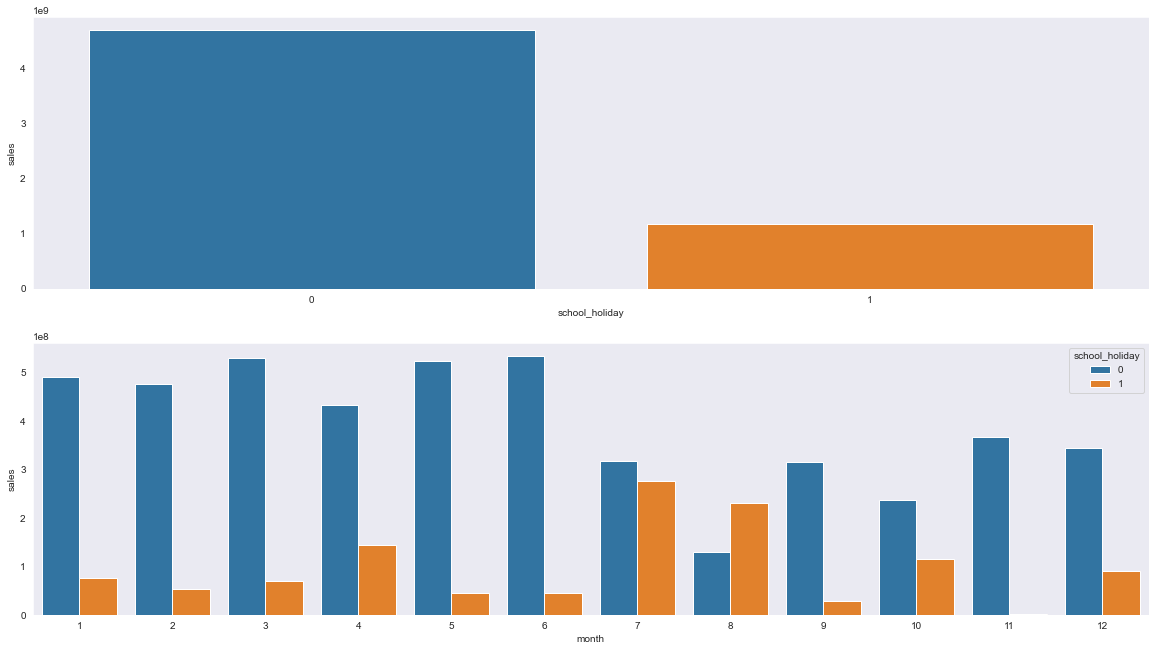

In [43]:
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2, 1, 1)
sns.barplot(x = 'school_holiday', y='sales', data=aux);


aux1 = df4[['school_holiday', 'month', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2, 1, 2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data=aux1);

## 4.3 Análise Multivariada

### 4.3.1 Variável Numérica 

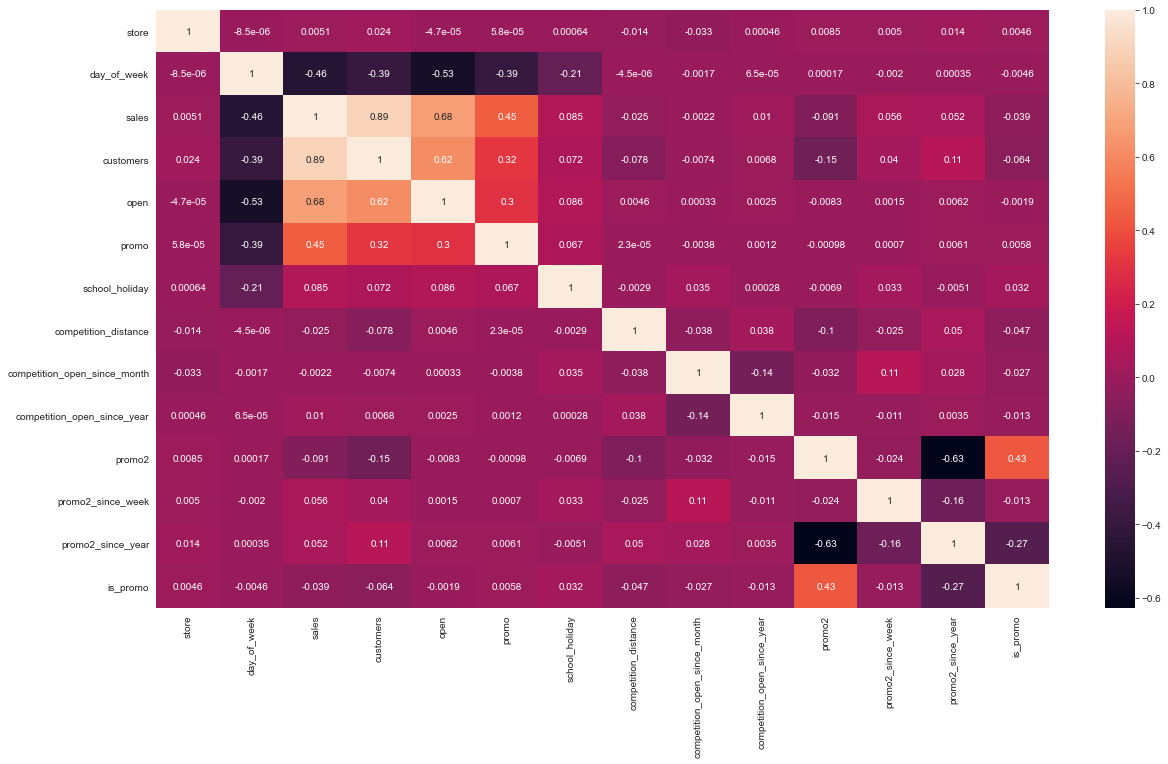

In [44]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True);

### 4.3.1 Variável Categórica

# 5. DATA PREPARATION

In [45]:
df5 = df4.copy()

## 5.1 Normalização

In [46]:
#Normalização não pode ser utilizado pois nenhuma variável tem algum tipo de distribuição normal;

## 5.2 Rescaling

In [47]:
a = df5.select_dtypes( include = ['float64', 'int32', 'int64'])

In [48]:
rs = RobustScaler()
mms = MinMaxScaler()
#competition distance
df5 ['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)


#competition time month
df5 ['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# Perceba promo time week não é tão forte os outliers, podemos utilizr o min max scaler

df5 ['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)


#year
df5 ['year'] = mms.fit_transform(df5[['year']].values)

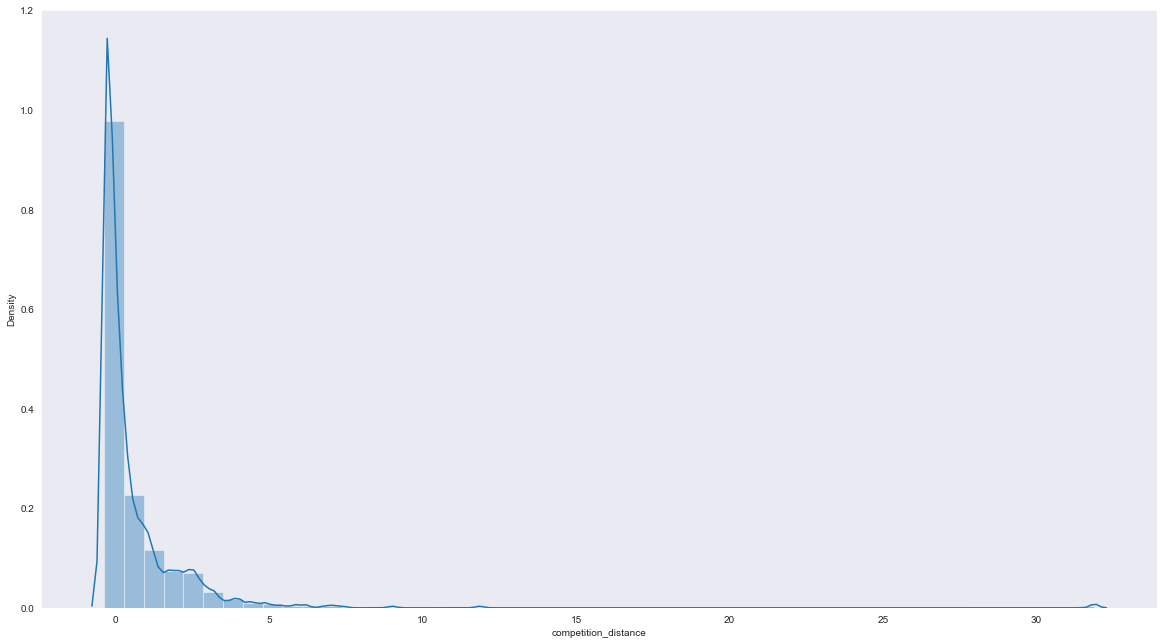

In [49]:
sns.distplot(df5['competition_distance']);

## 5.3 Transformação

### 5.3.1. Encoding

In [50]:
#state holiday - One hot Encoding -> Utilizando one hot pois state_holiday é um tipo de estado
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

#store_type - Não há uma ordem, então, vamos utilizar o Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

#assortment -> Há uma ordem, portanto, vamos utilizar o ordinal enconding
#Criamos um dicionário para isso e depois utilizamos o método "map" para encontrar os respectivos valores no df
assortment_dict = {'basic': 1, 'extended':2, 'extra': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

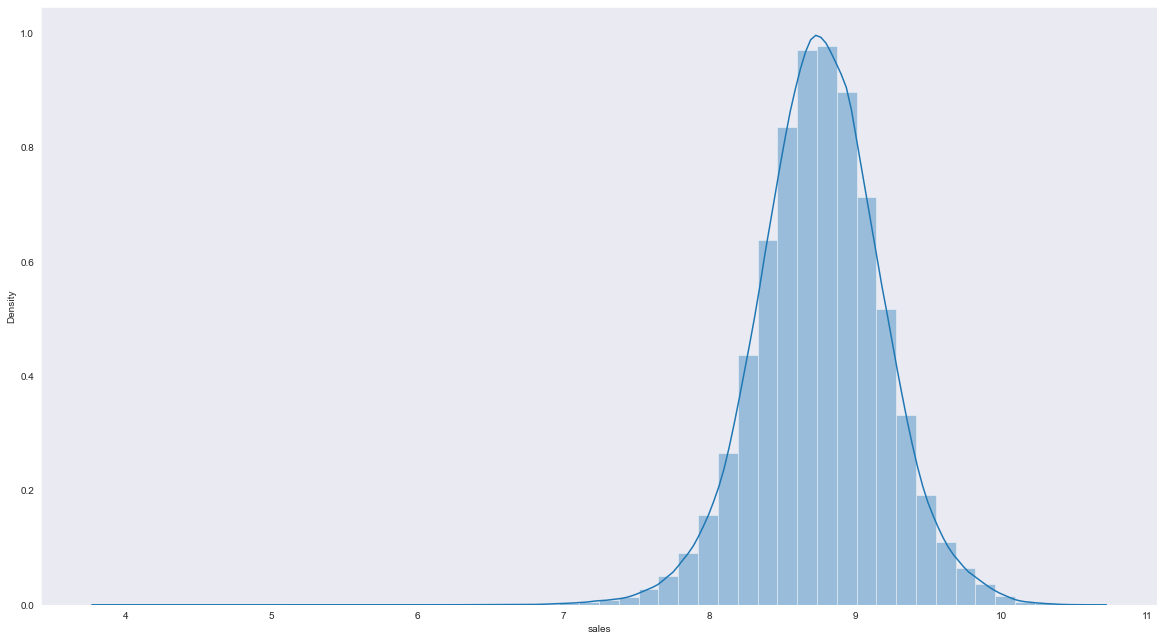

In [51]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales']);

### 5.2.4 Nature Transformation

In [52]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2*np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2*np.pi/7) ) )
#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2*np.pi/12) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2*np.pi/12) ) )
#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2* np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2* np.pi/52) ) )

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2* np.pi/30) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2* np.pi/30) ) )



In [53]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148


# 6.0 - Feature Selection

In [54]:
df6 = df5.copy()
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
3,4,5,2015-07-31,9.546527,1,1,2,2,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148


## 6.1 Split dataframe into training and test dataset

In [55]:
#Primeiramente vamos tropar as colunas que já foram derivadas;
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [56]:
#Vamos agrupar as vendas das primeiras lojas para verificarmos o primeiro dia de venda e o último;
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)
#Observe que este valor é o valor da última data menos 7 semanas; Toda a data anterior à esta será o nosso teste;

Timestamp('2015-06-19 00:00:00')

In [57]:
#Como precisamos fazer uma previsão de venda de 6 semanas, é interessante separarmos as 7 semanas anterior à primeira data de venda até o começo das vendas em treino;
#Da mesma forma, do tempo do treino até a ultima data de venda, será nosso teste; Acompanhe a seguir:


#Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']


#Test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']



#Printting

print('Training min Date: {}'.format(X_train['date'].min() ) )
print('Training max Date: {}'.format(X_train['date'].max() ) )


print('\n Test min Date: {}'.format(X_test['date'].min() ) )
print('Test max Date: {}'.format(X_test['date'].max() ) )



Training min Date: 2013-01-01 00:00:00
Training max Date: 2015-06-18 00:00:00

 Test min Date: 2015-06-19 00:00:00
Test max Date: 2015-07-31 00:00:00


In [58]:
X_train.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos
47945,1,2015-06-18,8.443762,1,0,2,1,-0.170968,9,2008,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709,-0.587785,-0.809017
47946,2,2015-06-18,8.547722,1,0,0,1,-0.283871,11,2007,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709,-0.587785,-0.809017
47947,3,2015-06-18,8.927712,1,0,0,1,1.903226,12,2006,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709,-0.587785,-0.809017
47948,4,2015-06-18,9.091669,1,0,2,2,-0.275806,9,2009,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709,-0.587785,-0.809017
47949,5,2015-06-18,8.502080,1,0,0,1,4.448387,4,2015,...,0,1,-0.433884,-0.900969,1.224647e-16,-1.0,0.120537,-0.992709,-0.587785,-0.809017


## 6.2 Boruta as Feature Selector

In [59]:
#training and test for boruta
#Precisamos dropar a coluna 'date' e sales
#X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
#y_train_n = y_train.values.ravel()


#define random forest regressor
#rf = RandomForestRegressor(n_jobs =-1)


#define Boruta
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)




#O BORUTA LEVA EM MÉDIA 4-5HORAS PARA RODAR, PORTANTO, PEGAREMOS OS RESULTAODS JÁ PRONTOS PARA EVITAR RODAR NOVAMENTE!

In [60]:
#Selecionando as variáveis que o boruta escolheu como mais relevantes
#cols_selected = boruta.support_.tolist()

#Best features selected by boruta
#X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
#cols_selected_boruta = X.train_fs.iloc[:, cols_selected].columns

#not selected boruta - O que tem no selecionado pelo boruta que não temos no nosso DS normal?
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [61]:
cols_selected_boruta = [
    'store',
    'promo', 
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']


#columns to add
feat_to_add = ['date', 'sales']
#cols_selected_boruta.extend(feat_to_add)

In [62]:
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning modelling

In [63]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 Average Model 

In [64]:
#Average model é a média de cada loja
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()


#prediction -> média das vendas por loja
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})

#join no dataset original

aux1 = pd.merge(aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1['predictions']

#performance

#Criando uma função que calcula os erros;
#Perceba que calculamos o sales na aba "data preparations", em 5.3.2. Para voltarmos aos dados normais, basta que passemos esta variável para o exponencial;
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))


In [65]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,3.367722e+06


## 7.2 Linear Regression


In [66]:
#model
lr = LinearRegression().fit(x_train, y_train)

#predict
yhat = lr.predict(x_test)

#Erros
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat))
lr_result

#Perceba o resultado de RMSE gigantesco. Forte indício de que nosso modelo não pode ser linearmente previsto;



,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1861.127229,0.291652,7.087795e+06


## 7.3 Lasso

In [67]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#predict
yhat= lrr.predict(x_test)

#Erros
lrr_result = ml_error('Lasso', np.expm1(y_test), np.expm1(yhat))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,1891.398669,0.289252,7.526570e+06


## 7.4 Random Forest Regressor

In [68]:
#model
rf = RandomForestRegressor(n_estimators = 100, 
                          n_jobs = -1,
                          random_state = 42).fit(x_train, y_train)

#predict
yhat = rf.predict(x_test)

#Erros
rf_result = ml_error('RandomForest', np.expm1(y_test), np.expm1(yhat))
rf_result


,Model Name,MAE,MAPE,RMSE
0,RandomForest,679.89109,0.099924,1.024064e+06


## 7.5 XGBoost

In [69]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=100, max_depth=10, eta = 0.01, colsample_bytree = 0.9).fit(x_train, y_train)

#predict
yhat = model_xgb.predict(x_test)

#Erros
xgb_result = ml_error('XGBoost', np.expm1(y_test), np.expm1(yhat))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost,6683.395548,0.949497,5.373190e+07


## 7.6 Compare Model's Performance

In [70]:
modelling_result = pd.concat([baseline_result,lr_result, lrr_result,  rf_result, xgb_result])
modelling_result.sort_values('RMSE')

#Perceba que todos esses modelos tem uma RMSE, ou seja, um erro, bastante elevado. Isto é sinal de que o nosso modelo de predição é extremamente completo ->
#e, logo, não pode ser linearmente modelado.

#Além isso, qual modelo devemos utilizar? Por intuição o RMSE, o que tem o menor erro, certo? Errado!
#É importante que façamos uma cross-validation!


,Model Name,MAE,MAPE,RMSE
0,RandomForest,679.891090,0.099924,1.024064e+06
0,Average Model,1354.800353,0.206400,3.367722e+06
0,Linear Regression,1861.127229,0.291652,7.087795e+06
0,Lasso,1891.398669,0.289252,7.526570e+06
0,XGBoost,6683.395548,0.949497,5.373190e+07


## 7.7 Compare real model's performance

In [71]:
x_training = X_train[cols_selected_boruta_full]


In [72]:
#Linear Regression
model = LinearRegression()
lr_result_cv = cross_validation(x_training, 5, 'Regressão Linear', model)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Regressão Linear,2077.72 +/- 295.95,0.3 +/- 0.02,8896307.41 +/- 2993013.07


In [73]:
#Linear Regression Regularized
model = Lasso(alpha = 0.01)
lasso_result_cv = cross_validation(x_training, 5, 'Lasso', model)
lasso_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.99 +/- 342.74,0.29 +/- 0.01,9608535.07 +/- 3339978.02


In [74]:
#Random Forest
model = RandomForestRegressor(n_estimators = 100, 
                          n_jobs = -1,
                          random_state = 42)
rf_result_cv = cross_validation(x_training, 5, 'Random Forest', model)
rf_result_cv

KeyboardInterrupt: 

In [75]:
#XGBoost Regressor
model = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators=100, max_depth=10, eta = 0.01, colsample_bytree = 0.9)
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost', model, verbose = True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost,7048.82 +/- 588.11,0.95 +/- 0.0,59987028.21 +/- 10951039.89


In [77]:
#Modelling Result CV
modelling_result_cv = pd.concat([lr_result_cv, lasso_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')


#Como esperado, os erros estão altos. Fica claro que o modelos lineares não se ajustam bem ao fato que estamos tentando prever;

SyntaxError: unexpected EOF while parsing (<ipython-input-77-3dfd14377dab>, line 6)

# 8. Hyperparameter fine tuning

## 8.1. Random Search

In [66]:
#import random

In [67]:
## 8.2 Final Model
#param = {
        #'n_estimators': [150, 170, 250, 300, 350],
       #'eta': [0.01, 0.03],
        #'max_depth': [3, 5, 9],
        #'subsample': [0.1, 0.5, 0.7],
        #'colsample_bytree': [0.3, 0.7, 0.9],
       # 'min_child_weight': [3, 8, 15]
       # }

#creating a max value to permitting iteration
#MAX_EVAL = 2

In [68]:
#final_result = pd.DataFrame()



#for i in range(MAX_EVAL):
    #choose values for parameters randomly
    #hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    #print(hp )



    #Creating dictionaries to iterate randomly
    #model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                            # n_estimators=hp['n_estimators'], 
                             #max_depth=hp['max_depth'], 
                            # eta = hp['eta'],
                            # colsample_bytree = hp['colsample_bytree'],
                             #min_child_weight = hp['min_child_weight'])

    #performance
    #result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose = False)
    #final_result = pd.concat([final_result, result])
    
#final_result

## 8.2 Final Model

In [84]:
param_tuned = {
        'n_estimators': 3000,
        'eta': 0.03,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'min_child_weight': 3
        }


In [85]:
#Using paramaters that were got in boruta
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators=param_tuned['n_estimators'], 
                             max_depth=param_tuned['max_depth'], 
                             eta = param_tuned['eta'],
                             colsample_bytree = param_tuned['colsample_bytree'],
                             min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction 
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,771.618904,0.116828,1.222686e+06


# 9. Tradução e interpretação do erro

In [86]:
df9 = X_test[ cols_selected_boruta_full ]
df9.head()

#rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performance

In [87]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df92 = pd.merge(df91, df9_aux3, how = 'inner', on ='store')
df92

,store,predictions,MAE,MAPE
0,1,168539.296875,291.889721,0.067762
1,2,181334.968750,409.613723,0.083394
2,3,267220.812500,616.390005,0.085351
3,4,346283.843750,834.608069,0.079653
4,5,175695.265625,434.575558,0.103061
...,...,...,...,...
1110,1111,182019.062500,633.160532,0.143237
1111,1112,339609.750000,990.622440,0.120643
1112,1113,250674.312500,553.494365,0.086163
1113,1114,785611.812500,2001.334618,0.085412


In [88]:
#Worst and Best Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']


In [89]:
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]
df92.sample(15)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
410,411,332056.750000,331175.473870,332938.026130,881.276130,0.090791
445,446,193610.812500,192846.884957,194374.740043,763.927543,0.180024
845,846,346995.593750,346120.423129,347870.764371,875.170621,0.099204
1106,1107,228736.781250,227883.995645,229589.566855,852.785605,0.135359
473,474,273100.125000,272474.923828,273725.326172,625.201172,0.095441
856,857,272439.562500,271322.847010,273556.277990,1116.715490,0.127741
691,692,237204.218750,236441.122605,237967.314895,763.096145,0.118602
470,471,257457.515625,256889.426151,258025.605099,568.089474,0.080001
981,982,297702.875000,296909.327267,298496.422733,793.547733,0.093672
982,983,334812.500000,333758.722115,335866.277885,1053.777885,0.143719


In [90]:
#Formating values
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$286,981,248.00"
1,worst_scenario,"R$286,117,462.33"
2,best_scenario,"R$287,845,044.97"


In [91]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

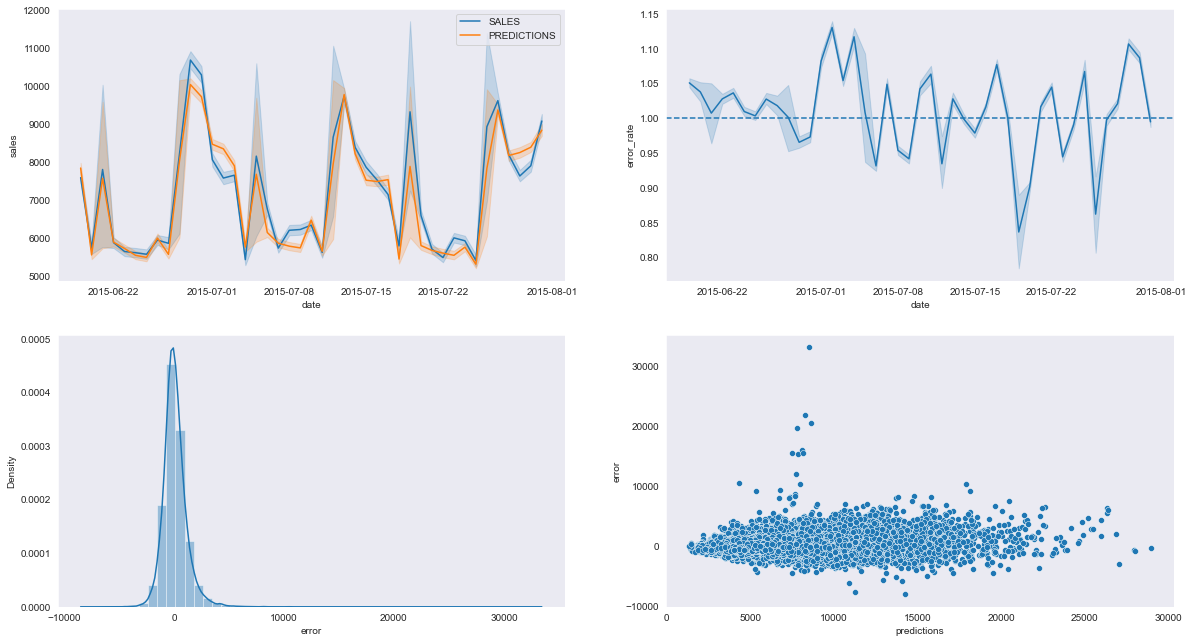

In [92]:

plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10 - Deploy to production

In [93]:
pickle.dump(model_xgb_tuned, open('C:/Users/Joâo Victor/Desktop/DS em Produção/model_rossmann.pkl', 'wb'))

## 10.1 - Rossman Class

In [80]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/Joâo Victor/Desktop/DS em Produção'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 - Handler

In [81]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from Rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:/Users/Joâo Victor/Desktop/DS em Produção/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

ModuleNotFoundError: No module named 'Rossmann'

## 10.3 API Tester

In [70]:
#Loading training dataset
df10 = pd.read_csv('C:/Users/Joâo Victor/Desktop/DS em Produção/test.csv')

In [78]:
import requests

In [74]:
#merge
df_test = pd.merge(df10, df_store_raw, how = 'left', on='Store')

#choose store for prediction
df_test = df_test[df_test['Store'] == 22]

#remove closed days
df_test = df_test[df_test['Open']!= 0]
df_test = df_test[~df_test['Open']!= 0]
df_test = df_test.drop('Id', axis = 1)

In [76]:
#Convert DataFrame to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [82]:
#API Call
url = 'http://0.0.0.0:5000/rossman/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data = data, headers = header )
print('Status Code{}'.format( r.status_code ) )

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /rossman/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000011E57DCED48>: Failed to establish a new connection: [WinError 10049] O endereço solicitado não é válido no contexto'))